In [1]:
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import scipy.special
import random
from mpmath import mp
import time
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
#NUMPY.Meshgrid seems promising


In [2]:
def Bessel(x,l):
    return sp.special.spherical_jn(l,x)


In [3]:
mp.dps = 200 # accurate up to 100 decimal places.

In [4]:
def FillFacTuple(x_max,Prefactor = mp.mpf(1.),Exponent = 0):
    # returns the faculty. More specific: Returns A,B in the form fac(x) = A* (10**6) **B
    #WATCH OUT: x has to be integer!!!
    
    if(x_max != int(x_max)):
        print("X_MAX HAS TO BE AN INTEGER")
    
    x = x_max #oops
    
    FacTuple =[-1]*(x_max*2+2)
    
    x = int(x)
    
    for i in range(1,x+1):
        
        if(Prefactor*i < 10**6):
            Prefactor *= i
            FacTuple[2*i] = np.array([Prefactor, Exponent])
        
        else:
            Prefactor = Prefactor /mp.mpf(10**6)
            Prefactor *=i
            Exponent += 1
            FacTuple[2*i] = np.array([Prefactor, Exponent])
            
            
    FacTuple[0] = np.array([mp.mpf(1.),0.])
    
    x = x+0.5
    
    Prefactor = mp.sqrt(mp.pi)/2
    Exponent = 0
    for i in range(3, int(2*x)+1,2):

        if(Prefactor*i < 10**6):
            Prefactor *= i/2
            FacTuple[i] = np.array([Prefactor, Exponent])
        else:
            Prefactor = Prefactor /mp.mpf(10**6)
            Prefactor *=i/2
            Exponent += 1
            FacTuple[i] = np.array([Prefactor, Exponent])

    FacTuple[1] = np.array([mp.sqrt(mp.pi)/2,0])
    
    return FacTuple

FacTuple = np.array(FillFacTuple(7000))

In [5]:
def fac(x):

    if(type(x) == np.ndarray):
        y = (2*x).astype(int)
        return FacTuple[y].transpose()
    
    return FacTuple[int(2*x)]



In [6]:


def Reduced_E(a,b,c): #so far only suitable for scalar a,b,c.

    a1,b1 = fac(a+b+c+1)
    a2,b2 = fac(1/2.*(a+b-c))
    a3,b3 = fac(1/2.*(a-b+c))
    a4,b4 = fac(1/2.*(-a+b+c))

    a5,b5 = fac(a+b-c)
    a6,b6 = fac(1/2.*(a+b+c))

    return np.array([a1*a2*a3*a4/(a5*a6),b1+b2+b3+b4-b5-b6])





In [7]:
def Triangle(a,b,c):
    if((a+b+c)%2==0):
        if(abs(a-b)<=c<=a+b):
            if(abs(b-c)<=a<=b+c):
                if(abs(a-c)<=b<=a+c):
                    return 1
    return 0
    
def WeakTriangle(a,b,c):    
    if(abs(a-b)<=c<=a+b):
        if(abs(b-c)<=a<=b+c):
            if(abs(a-c)<=b<=a+c):
                return 1
    return 0
    
    
def E(a,b,c):
    
    if(Triangle(a,b,c)==0):
        
        return mp.mpf(1)* np.array([0,0])
    
    return Reduced_E(a,b,c)

def Teta(k1,k2,k3):
    
    if(abs(k1-k2)<k3<abs(k1+k2)):
        return 1
    
    if(abs(k1-k2)==k3 or abs(k1+k2)==k3):
        return 0.5
    
    return 0
    
    


In [8]:
def Q_Modified(l3,L,k1,l1,k2,l2):
    
    if(Triangle(l2,l1,l3)==0): 
                
        return mp.mpf(0)

    
    a_pre,b_pre = E(l2,l1,l3)

    prefactor = a_pre*(-1)**(int((l3-l1+l2)/2))*(2*L+1)/2

    
    
    #Sumarray = [] #here I add the terms of the sum in the form A * (10**6)**B
    #Not Finished Yet. Must Fix.
    Qsum = 0
    
    jList = np.array(range(abs(L-l2),l3-abs(L-l1)+1,2))


    a_sum1, b_sum1 =  Reduced_E(l1,L,l3-jList) # Reduced, because E contains an if statement that is usually True anyway.
    a_sum2, b_sum2 =  Reduced_E(l2,L,jList) #

        
    Q_part = ((-k2/k1).reshape(len(k1),1))**jList /(a_sum1*a_sum2)

    
    Qsum = Q_part.dot((mp.mpf((10**6)))**(b_pre-b_sum2-b_sum1)) #THESE TWO LINES TAKE MOST TIME. For l = 100 it takes 153 of 190 seconds.


        
        
        #if(E(l2,L,j) == 0):
    

    
    
    return prefactor*Qsum

#Q_Modified(6,np.array([6,6]),1,6,1,6)


In [9]:
def J_Modified(l1,l2,l3,k1,k2,k3):
    

    #ReturnableArray = np.array([-1]*len(k1))
    
    #for i in range(len(k1)):
    #    if (Teta(k1[i],k2[i],k3[i]) == 0):
        
    #        ReturnableArray[i]=0
     #Teta is equal to 1 anyway, if we choose alpha and beta accordingly.

    
    mu = ((k1**2+k2**2-k3**2)/(2*k1*k2))
    
    


    prefactor = np.pi/((2*k1*k2))*((k1/k3))**l3 *1/k3 #*Teta(k1,k2,k3)
    

    Lsum = mp.mpf(1.)*np.array([0.]*len(prefactor))

    Lower = (l1+l2-l3)//2
    
    for L in range(Lower,(l1+l2+l3)//2+1):
        
        Mult = Q_Modified(l3,L,k1,l1,k2,l2)

        #unfortunately, mp.legendre doesnt accept arrays as arguments :-(
        
        Legendrearr = np.array([mp.legendre(L,mu_entry) for mu_entry in mu])

        Lsum += Mult*Legendrearr


    return prefactor * Lsum   #here: replace l with l3



In [10]:
def ReduceArrays(Alphas,Betas):
    
    Valid_Indices = []
    
    for i in range(len(Alphas)):
        if(Alphas[i]<=1-Betas[i]):
            if(Alphas[i]>=-(1-Betas[i])):
                Valid_Indices.append(i)
    
    
    return Valid_Indices

In [12]:
def Int_G_Meshgrid(alpha_array,beta_array,l1,l2 = 0,l3 = 0):
    #Currently only accepts numpy arrays as alpha/beta array.
    #returns the integral over the 3 bessel functions. analytical.
    
    #What I am currently doing: Check that The Alphas and Betas fulfill the "triangle condition", i.e. -(1-b)<=alph<=1-b
    #then calculate the integral with the remaining ones, then put every remaining pair of alpha/beta to zero.
    
    if(l2 == 0 or l3 == 0):
        l2 = l1
        l3 = l1
    
    shape = alpha_array.shape
    
    alpha_array = alpha_array.flatten()
    beta_array = beta_array.flatten()
    
    #start = time.time()
    Indices  = ReduceArrays(alpha_array,beta_array)
    #end = time.time()
    
    #print(end-start) #takes about 3ms
    
    
    red_alpha_array = alpha_array[Indices]
    red_beta_array = beta_array[Indices]
    
    #converts the arrays to mpfloats
    a_arr = mp.mpf(1.)*(1-red_beta_array)
    b_arr = mp.mpf(1.)*1./2*(1+red_alpha_array+red_beta_array)
    c_arr = mp.mpf(1.)*1./2*(1-red_alpha_array+red_beta_array)

    
    Integral_Array = J_Modified(l1,l2,l3,a_arr,b_arr,c_arr)
    
    Values = np.zeros(len(alpha_array))
    
    Values[Indices] = Integral_Array #this one overwrites the zeros with the actual values at the right position.
    
    Values = Values.reshape(shape)
    
    return Values


In [13]:
def K_Equilateral_Ints(l1,l2,l3,k_list = np.linspace(0.00001,0.1,100)):
    
    
    Integral_Array = J_Modified(l1,l2,l3,k_list,k_list,k_list)
    
    for i in range(len(k_list)):
        if(k_list[i] == 0):
            Integral_Array[i] = 0
    
    return k_list, Integral_Array


#Equilateral_k_list = np.logspace(-5,-1,100)

#k, Equilateral_vals = K_Equilateral_Ints(100,100,100,k_list = Equilateral_k_list)


In [14]:
def L_Equilateral_k_flattened(l,k3):
    
    #NOTE TO MYSELF: I calculate this integral WITHOUT the extra Teta factor. The Teta factor would
    #correspond to an extra factor of 1/2.
    
    k1 = k3/2
    k2 = k3/2
    
    
    Integral_Array = J_Modified(l,l,l,k1,k2,k3)
    
    
    
    return Integral_Array



In [15]:
def L_Equilateral_CutThrough(l,k_sum,k1,k2):
    
    #takes k1, k2 returns the corresponding Integral in 1D form.
    
    k1 = mp.mpf(1.)*k1
    k2 = mp.mpf(1.)*k2
    
    k3 = mp.mpf(k_sum) - (k1+k2)

    Samples = J_Modified(l,l,l,k1.flatten(),k2.flatten(),k3.flatten())
    
    #now k1,k2,k3 are matrices.

    return Samples



In [21]:
beta_initial = np.linspace(0.0001,0.999,400) # np.linspace(0,1,30) for standard accuracy
alpha_initial = np.linspace(-1,1,400) 

AlphaArray, BetaArray = np.meshgrid(alpha_initial,beta_initial)



In [17]:
XMax = 400.    #XMax = 1000. for standard accuracy
XSteps = 4000  #XSteps = 10000 for standard accuracy
Stepwidth = XMax/XSteps
x = np.arange(0,XMax,Stepwidth)



def Int_G_Num(alpha,beta,l,x_sample = np.arange(0,1000,10000),Valueonly = True):
    
    a = np.array(1-beta)
    b = np.array((1+alpha+beta)/2.)
    c = np.array((1-alpha + beta)/2.)
    
    BesA = Bessel(np.tensordot(a,x_sample,0),l)
    BesB = Bessel(np.tensordot(b,x_sample,0),l)
    BesC = Bessel(np.tensordot(c,x_sample,0),l)
    
    Stepwidth = x_sample[3]-x_sample[2] #assuming linearly spaced x


    if (Valueonly == True):
        return Stepwidth*((x**2).dot((BesA*BesB*BesC).transpose()))
    
    return Stepwidth*((x**2).dot((BesA*BesB*BesC).transpose()))#,x_sample,x_sample**2*BesA*BesB*BesC




In [18]:
shape = AlphaArray.shape
    
alpha_array = AlphaArray.flatten()
beta_array = BetaArray.flatten()
    
    #start = time.time()
Indices  = ReduceArrays(alpha_array,beta_array)
    #end = time.time()
    
    #print(end-start) #takes about 3ms
    
    
red_alpha_array = alpha_array[Indices]
red_beta_array = beta_array[Indices]
print(len(red_alpha_array),len(AlphaArray))
Integral_Array = Int_G_Num(red_alpha_array,red_beta_array,7,x)



    
Values = np.zeros(len(alpha_array))
    
Values[Indices] = Integral_Array #this one overwrites the zeros with the actual values at the right position.
    
Values = Values.reshape(shape)
np.save("DataDreieckMashgridNumerical_7",Values)

40050 400
ALMOST DONE


In [37]:
l_arr = [82]

for L in l_arr:
    Data = Int_G_Meshgrid(AlphaArray,BetaArray,L,L,L).astype(float)
    np.save("DataDreieckMashgrid{:}".format(L),Data)
    print(L)
    print()
    

82



In [18]:

Data = Int_G_Meshgrid(AlphaArray,BetaArray,20,10,10).astype(float)

In [19]:
np.save("DataDreieckMashgrid_20_10_10",Data)


In [22]:
Data = Int_G_Meshgrid(AlphaArray,BetaArray,6,12,10).astype(float)

In [23]:
np.save("DataDreieckMashgrid_6_12_10",Data)


In [89]:
print("Ugh,Lightsaber??")

Data = Int_G_Meshgrid(AlphaArray,BetaArray,2,30,30).astype(float)

Ugh,Lightsaber??


In [90]:
np.save("DataDreieckMashgrid_2_30_30",Data)
np.save("AlphaDreieckMashgrid_2_30_30",AlphaArray)
np.save("BetaDreieckMashgrid_2_30_30",BetaArray)

In [92]:
print("YOU NEED A LIFESAVER")

Data = Int_G_Meshgrid(AlphaArray,BetaArray,2,40,40).astype(float)

YOU NEED A LIFESAVER


In [93]:
np.save("DataDreieckMashgrid_2_40_40",Data) #might have saved wrong data here....
np.save("AlphaDreieckMashgrid_2_40_40",AlphaArray)
np.save("BetaDreieckMashgrid_2_40_40",BetaArray)

In [21]:
n = 323564

AlphaArray = AlphaArray.reshape(n) #because these plot routines only accept 2D arrays.
BetaArray = BetaArray.reshape(n)
Data = Data.reshape(n)

(40495,)


(200, 200)


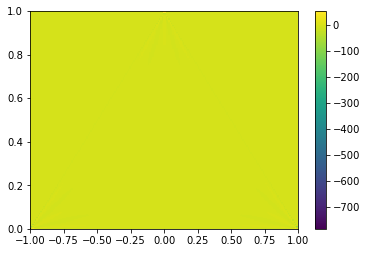

In [57]:

X = AlphaArray
Y = BetaArray
Z = Data.astype(float)
print(Z.shape)
plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()

In [114]:
Samplecoordinates = []
xvector = np.array([0,1])
yvector = np.array([np.sqrt(3),-1])/2
Samplecoordinates = (np.tensordot(xvector,k1.flatten(),0)+np.tensordot(yvector,(k_sum/2-k2.flatten()),0))

Ones = np.ones(len(Samplecoordinates[0])).reshape(sample_points[0],sample_points[1])
yCoordinates = Samplecoordinates[0].reshape(sample_points[0],sample_points[1])
xCoordinates = Samplecoordinates[1].reshape(sample_points[0],sample_points[1])

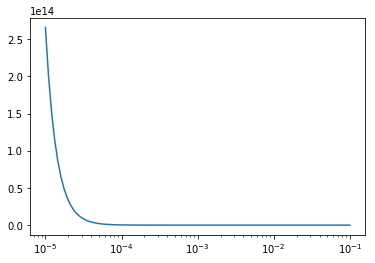

In [37]:
#plt.semilogx(Flattened_k_list,Flattened_vals)
plt.semilogx(Equilateral_k_list,Equilateral_vals)
plt.show()

In [18]:

plt.plot(lList, Amplitude)
#plt.plot(lList)
plt.xlabel(r"$\ell$",fontsize = 14)
plt.ylabel(r"Amplitude A",fontsize = 14)
plt.ylim(0,0.6)

plt.show()

NameError: name 'lList' is not defined

In [17]:
def J(l,k1,k2,k3):
    
    if (Teta(k1,k2,k3) == 0):
        
        return 0
    
    mu = (k1**2+k2**2-k3**2)/(2*k1*k2)

    
    prefactor = Teta(k1,k2,k3)*np.pi/(2*k1*k2*k3**(l+1))

    
    Lsum = 0
    if(l%2 == 0):
        Lower = l//2
        
    else:
        Lower = l//2+1

    
    for L in range(Lower,3*l//2+1):
        
        Mult = Q(l,L,k1,l,k2,l)
        

        
        Lsum += Mult*sp.special.eval_legendre(L,mu)



    
    return prefactor * Lsum



In [23]:
def Q(l3,L,k1,l1,k2,l2):
    
    if(Triangle(l2,l1,l3)==0): 
                
        return 0

    
    a_pre,b_pre = E(l2,l1,l3)
    prefactor = (-1)**(int((l3-l1+l2)/2))*(2*L+1)*a_pre/2

    
    
    #Sumarray = [] #here I add the terms of the sum in the form A * (10**6)**B
    #Not Finished Yet. Must Fix.
    Qsum = 0
    for j in range(abs(L-l2),l3-abs(L-l1)+1,2):

        
        a_sum1, b_sum1 =  E(l1,L,l3-j) #
        a_sum2, b_sum2 =  E(l2,L,j) #


        
        
        Q_part =(-1)**j*k1**(l3-j)*k2**j/(a_sum1*a_sum2)

        Qsum += Q_part*(10**6)**(b_pre-b_sum2-b_sum1)
        

        
        
        
        #if(E(l2,L,j) == 0):
    

    
    
    return prefactor*Qsum



In [24]:
#%timeit AlphaArray*AlphaArray*AlphaArray


In [25]:
#%timeit(Int_G_Num(AlphaArray,BetaArray,6,x))

%timeit Int_G(AlphaArray,BetaArray,100) # takes 3 minutes 35seconds per run, only 3min 01 s if vectorized
%timeit Int_G_Num(AlphaArray,BetaArray,100,x) #takes 1minute 13 seconds per run with quite low accuracy.


NameError: name 'TimeMeasures' is not defined

In [26]:
#CREATING RUNTIME PLOT
#CREATING RUNTIME PLOT
#CREATING RUNTIME PLOT



Llist = [2,4,6,8,10,12,14,16,20,24,28,32,36,40,44,48,52,56,64,72,80,88,96,100,110,120,130,140]
TimeList100, TimeList200, TimeList500 = [],[],[]
TimeList_Num = []

for L in Llist:
    
    mp.dps = 100
    start = time.time()
    Int_G(AlphaArray[::30],BetaArray[::30],L)
    end = time.time()
    TimeList100.append(end-start)
    
    mp.dps = 200
    start = time.time()
    Int_G(AlphaArray[::30],BetaArray[::30],L)
    end = time.time()
    TimeList200.append(end-start)
    
    mp.dps = 500
    start = time.time()
    Int_G(AlphaArray[::30],BetaArray[::30],L)
    end = time.time()
    TimeList500.append(end-start)
    
    
    start = time.time()
    Int_G_Num(AlphaArray[::30],BetaArray[::30],L,x)
    end = time.time()
    TimeList_Num.append(end-start)
    
    print(L)



NameError: name 'TimeMeasures' is not defined

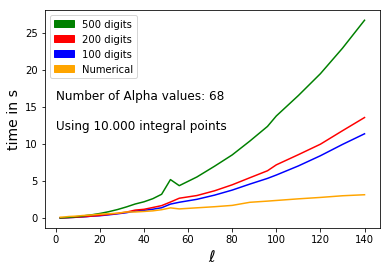

In [32]:
Grun = mpatches.Patch(label = "500 digits",color = "green")
Red = mpatches.Patch(label = "200 digits",color = "red")
Blau = mpatches.Patch(label = "100 digits",color = "blue")
Ora = mpatches.Patch(label = "Numerical",color = "orange")
plt.plot(Llist,TimeList100,"blue")
plt.plot(Llist,TimeList200,"red")
plt.plot(Llist,TimeList500,"green")
plt.plot(Llist,TimeList_Num,"orange")
plt.xlabel(r"$\ell$",fontsize = 16)
plt.ylabel("time in s",fontsize = 14)

plt.text(0,16,"Number of Alpha values: {:}".format(len(AlphaArray[::30])),fontsize = 12)
plt.text(0,12,"Using 10.000 integral points",fontsize = 12)

plt.legend(handles = [Grun,Red,Blau,Ora])

##plt.savefig("Runtime_comparison_digits.pdf",format = "pdf")
plt.show()


In [17]:
#testcell

a = np.array([1,2,3.4,5.2,7,9,0,564,0]).reshape(9,1)
b = np.array([2,3,5,6,8,89,9])


%timeit np.power(a,b)

%timeit a**b

The slowest run took 12.15 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.58 µs per loop
The slowest run took 4.40 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.64 µs per loop


In [18]:
def power(x):
    
    return np.power(x,np.array([2,3]),1)

power(np.array([2,3,9]))

TypeError: return arrays must be of ArrayType

In [159]:
Int_G(np.array([-0.9999]),np.array([0.0001]),6)









array([mpf('-7854.7671106769080487283221120111064437983482961959063239109210755586162020133348909541019034789444228510033471268583311624186480957214632590233344628033672430125013159184410548356939194451124263223673525')],
      dtype=object)